In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sqlalchemy import func

from models import Generation, Export, Question, AnswerChoice, PARSERS
from main import app
from db import db

context = app.app_context()
context.push()

/home/connor/Research/gpt-quiz-generation/quiz-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Time spent making quizzes

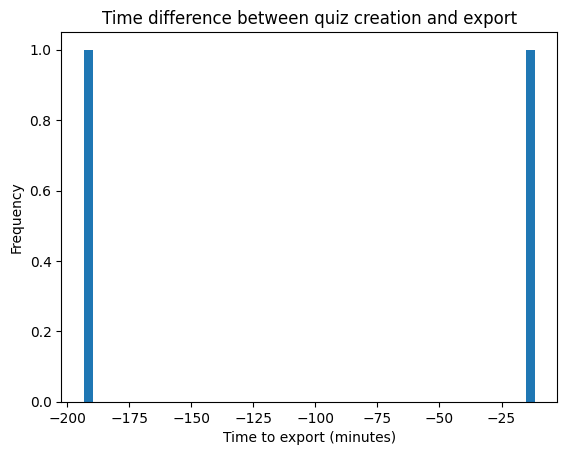

In [3]:
# get first export for each quiz
exports = (db.session.query(Generation.created_at.label("generation_created_at"), func.min(Export.created_at).label("earliest_export_created_at"))
           .join(Export)
           .group_by(Generation.id)
           .all())

# calculate delta between creation and export
df = pd.DataFrame(exports)
df["time_difference"] = df["earliest_export_created_at"] - df["generation_created_at"]

# convert timedelta to minutes
df["time_difference"] = df["time_difference"].dt.total_seconds() / 60

# create histogram
plt.hist(df["time_difference"], bins=50)
plt.xlabel("Time to export (minutes)")
plt.ylabel("Frequency")
plt.title("Time difference between quiz creation and export")
plt.show()

## Question and answer edits

In [102]:
from Levenshtein import distance
from IPython.display import display

# find levenshtein distance between original and current question
questions = Question.query.all()
questions = pd.DataFrame(questions)
questions["difference"] = questions.apply(lambda x: distance(x["original_question"], x["question"]), axis=1)
display(questions.nlargest(10, "difference")[["original_question", "question"]])

# find levenshtein distance between original and current answer choice
answers = AnswerChoice.query.all()
answers = pd.DataFrame(answers)
answers["difference"] = answers.apply(lambda x: distance(x["original_text"], x["text"]), axis=1)
display(answers.nlargest(10, "difference")[["original_text", "text"]])


,original_question,question
168,What is the main problem with using exceptions...,What is the main problem with using exceptions...
0,What is Functional Reactive Programming?,What is Functional Reactive Programming?
1,How does FrTime avoid glitches?,How does FrTime avoid glitches?
2,What is the output of the expression (string-l...,What is the output of the expression (string-l...
3,What type of time-varying value is seconds?,What type of time-varying value is seconds?
4,What is the output of the expression (add1 (cu...,What is the output of the expression (add1 (cu...
5,How does FrTime avoid certain glitches?,How does FrTime avoid certain glitches?
6,What is the output of the expression (string-l...,What is the output of the expression (string-l...
7,What is the purpose of FRP?,What is the purpose of FRP?
8,What is the output of the expression (string-l...,What is the output of the expression (string-l...


,original_text,text
653,It is not a standard approach in all programmi...,It is not a standard approach in all programmi...
652,It creates an inaccurate contract.,It creates an inaccurate contract.It creats an...
578,Rule eta,Rule etagdd
655,It is difficult to test for.,It is difficult to test for.v
0,A programming paradigm where what syntacticall...,A programming paradigm where what syntacticall...
1,A programming language where arguments are eva...,A programming language where arguments are eva...
2,A programming language whose evaluation model ...,A programming language whose evaluation model ...
3,A programming language which is fast and effic...,A programming language which is fast and effic...
4,By scheduling the graph to be updated in topog...,By scheduling the graph to be updated in topog...
5,By avoiding eager evaluations of time-varying ...,By avoiding eager evaluations of time-varying ...


## Question and answer deletions

In [103]:
# remove questions that contain > 30 insertions/deletions
EDIT_THRESHOLD = 30

# find percentage of questions either deleted or modified above threshold
questions = Question.query.with_deleted().all()
questions = pd.DataFrame(questions)
questions["difference"] = questions.apply(lambda x: distance(x["original_question"], x["question"]), axis=1)

percentage = questions.query(f"deleted == True | difference > {EDIT_THRESHOLD}").shape[0] / questions.shape[0] * 100
print(f"Questions deleted: {percentage:.2f}%")

# find percentage of answer choices either deleted or modified above threshold
answers = AnswerChoice.query.with_deleted().all()
answers = pd.DataFrame(answers)
answers["difference"] = answers.apply(lambda x: distance(x["original_text"], x["text"]), axis=1)

percentage = answers.query(f"deleted == True | difference > {EDIT_THRESHOLD}").shape[0] / answers.shape[0] * 100
print(f"Answers deleted: {percentage:.2f}%")

Questions deleted: 2.81%
Answers deleted: 0.70%


## Submitted content length

/home/connor/Research/gpt-quiz-generation/quiz-env/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/connor/Research/gpt-quiz-generation/quiz-env/lib/python3.8/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


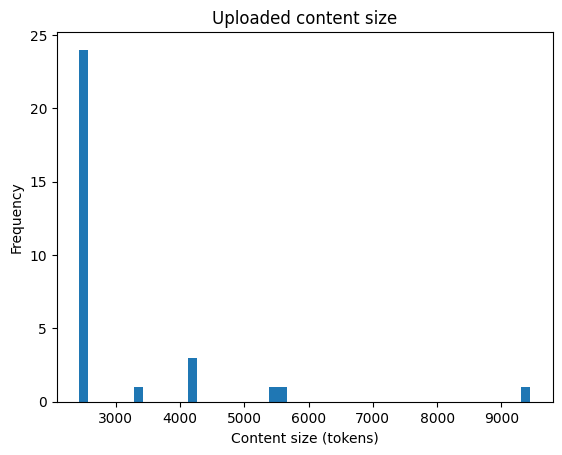

In [99]:
from lib.completion import chapter_tokens

def get_content_length(generation: Generation):
    parser = PARSERS[generation.content_type]
    filename = os.path.join(app.config["UPLOAD_FOLDER"], generation.unique_filename)

    with open(filename) as upload:
        parsed = parser(upload)

    return chapter_tokens(parsed)

generations = Generation.query.all()
generations = pd.DataFrame(generations)

generations["tokens"] = generations.apply(get_content_length, axis=1)

# create histogram
plt.hist(generations["tokens"], bins=50)
plt.xlabel("Content size (tokens)")
plt.ylabel("Frequency")
plt.title("Uploaded content size")
plt.show()